In [1]:
import os, sys
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

import sgml, sgutil, dproc

print(sys.version)
for i in [pd, np, lgb, xgb, mpl, sns]:
    try:
        print(i.__name__, i.__version__)
    except:
        pass

3.12.6 (main, Sep 30 2024, 02:19:13) [GCC 9.4.0]
pandas 2.2.3
numpy 2.1.2
xgboost 2.1.2
matplotlib 3.8.4
seaborn 0.13.2


# Preparation

In [2]:
data_path = 'data'
if not os.path.isdir(data_path):
    os.mkdir(data_path)

files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('org_train', data_path, 'train_org.csv'),
        ('org_test', data_path, 'test_org.csv'),
        ('train_pkl', data_path, 'train.pkl'),
        ('org_pkl', data_path, 'org.pkl'),
        ('test_pkl', data_path, 'test.pkl'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}
sc = sgutil.SGCache('img', 'result')

In [3]:
df_train = pd.read_pickle(files['train_pkl'])
df_test = pd.read_pickle(files['test_pkl'])
df_var = pd.read_pickle(files['var_pkl'])

In [4]:
df_org = pd.read_pickle(files['org_pkl'])

In [5]:
df_var

,var_type,Description,min,max,na,count,n_unique,f32,i32,i16,i8,dtype,src
Age,(continous),Age of the Customer.,20.0,85.0,0.0,19682810.0,66.00,True,True,True,True,Int8,NaN
Gender,(dichotomous),Gender of the Customer.,NaN,NaN,0.0,19682810.0,2.00,True,True,True,True,Categorical,NaN
Driving_License,(dichotomous),"0 for customer not having DL, 1 for customer h...",0.0,1.0,0.0,19682810.0,2.00,True,True,True,True,Int8,NaN
Region_Code,(nominal),Unique code for the region of the customer.,0.0,52.0,0.0,19682810.0,53.25,True,True,True,True,Categorical,NaN
Previously_Insured,(dichotomous),"0 for customer not having vehicle insurance, 1...",0.0,1.0,0.0,19682810.0,2.00,True,True,True,True,Categorical,NaN
Vehicle_Age,(nominal),Age of the vehicle.,NaN,NaN,0.0,19682810.0,3.00,True,True,True,True,Categorical,NaN
Vehicle_Damage,(dichotomous),Customer got his/her vehicle damaged in the pa...,NaN,NaN,0.0,19682810.0,2.00,True,True,True,True,Categorical,NaN
Annual_Premium,(continous),The amount customer needs to pay as premium in...,2630.0,540165.0,0.0,19682810.0,46734.25,True,True,False,False,Float32,NaN
Policy_Sales_Channel,(nominal),Anonymized Code for the channel of outreaching...,1.0,163.0,0.0,19682810.0,150.75,True,True,True,False,Categorical,NaN
Vintage,(continous),"Number of Days, Customer has been associated w...",10.0,299.0,0.0,19682810.0,290.00,True,True,True,False,Int16,NaN


In [6]:
target = 'Response'
X_cat = df_var.loc[(df_var['dtype'] == 'Categorical') & (df_var['src'] != 'combine_categories')].index.tolist()
X_bool = df_var.loc[(df_var['n_unique'] == 2) & (~df_var['dtype'].isin(X_cat))].index.tolist()
X_bool = [i for i in X_bool if i != target and i not in X_cat]
X_num = df_var.loc[~df_var.index.isin(X_cat + X_bool + ['id', 'Response (Dependent Feature)'])].index.tolist()
X_all = df_test.columns.tolist()
print("Target:", target)
print("Categorical:", np.array(X_cat))
print("Boolean:", np.array(X_bool))
print("Number:", np.array(X_num))

Target: Response
Categorical: ['Gender' 'Region_Code' 'Previously_Insured' 'Vehicle_Age'
 'Vehicle_Damage' 'Policy_Sales_Channel' 'Annual_Premium_c' 'Age_c'
 'Vintage_c']
Boolean: ['Driving_License' 'is_Annual_Premium_mode']
Number: ['Age' 'Annual_Premium' 'Vintage' 'VA' 'VAge' 'PA' 'VV' 'PAge' 'VP' 'PVc'
 'PP' 'RV' 'V2V' 'RP' 'PV2' 'PV' 'GV2' 'GP' 'AA' 'AV' 'VPAV' 'VPPV' 'VPPA'
 'VPVGAP' 'VPVGAV' 'VPVGAR' 'VPRV' 'VPVA' 'VPPAc' 'VPRAc']


In [7]:
df_train['log_Annual_Premium'] = np.log(df_train['Annual_Premium'])

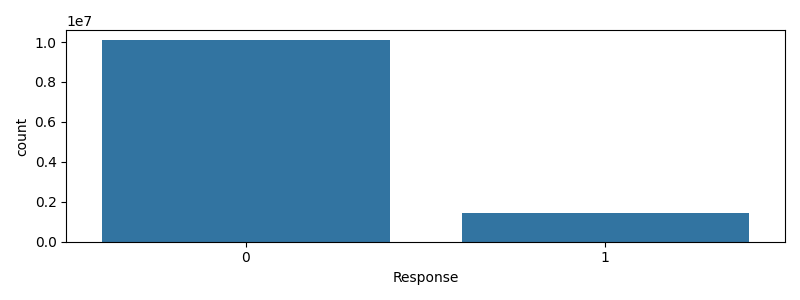

In [8]:
sc.cache_fig(
    'freq_target',
    lambda x: sns.barplot(df_train[target].value_counts(), ax=x), figsize=(8, 3)
)

In [9]:
sc.cache_result('target_ratio',
    lambda : df_train[target].value_counts(normalize=True)
)

Response
0    0.877003
1    0.122997
Name: proportion, dtype: float64

# Categorical Variables 

In [10]:
from scipy.stats import chi2_contingency

for i in X_cat + X_bool:
    df_conti = sc.cache_result('conti_{}'.format(i),
        lambda : df_train.pivot_table(index=i, columns=target, observed=True, aggfunc='size').fillna(0)
    )
    chi2_result = chi2_contingency(df_conti)
    print(i, chi2_result.pvalue, chi2_result.statistic)
    display(df_conti.pipe(lambda x: x.div(x.sum(axis=1), axis=0)).join(df_train[i].value_counts().rename('count')).sort_values('count', ascending=False))

Gender 0.0 35070.47775897216


,0,1,count
Gender,,,
Male,0.860312,0.139688,6228134
Female,0.896703,0.103297,5276664


Region_Code 0.0 260136.2635107171


,0,1,count
Region_Code,,,
28.0,0.808189,0.191811,3451062
8.0,0.912282,0.087718,1021036
46.0,0.903837,0.096163,578208
41.0,0.885869,0.114131,557581
15.0,0.932565,0.067435,403977
30.0,0.930500,0.069500,367307
29.0,0.883252,0.116748,338146
50.0,0.936021,0.063979,302334
11.0,0.892213,0.107787,278261


Previously_Insured 0.0 1376747.0852643573


,0,1,count
Previously_Insured,,,
0,0.771507,0.228493,6178116
1,0.999362,0.000638,5326682


Vehicle_Age 0.0 614768.9366370656


,0,1,count
Vehicle_Age,,,
1-2 Year,0.822275,0.177725,5982678
< 1 Year,0.958596,0.041404,5044145
> 2 Years,0.700950,0.299050,477975


Vehicle_Damage 0.0 1489195.7410118645


,0,1,count
Vehicle_Damage,,,
Yes,0.759470,0.240530,5783229
No,0.995802,0.004198,5721569


Policy_Sales_Channel 0.0 849225.1963285833


,0,1,count
Policy_Sales_Channel,,,
124.0,0.807504,0.192496,NaN
26.0,0.792237,0.207763,NaN
152.0,0.973778,0.026222,NaN
156.0,0.795073,0.204927,NaN
160.0,0.979304,0.020696,NaN
...,...,...,...
67.0,1.000000,0.000000,NaN
74.0,0.916667,0.083333,NaN
27.0,1.000000,0.000000,NaN


Annual_Premium_c 0.0 767199.6633386193


,0,1,count
Annual_Premium_c,,,
2630.0,0.872057,0.127943,2112914
38287.0,0.827754,0.172246,6363
39008.0,0.849007,0.150993,5285
38452.0,0.852574,0.147426,4721
28861.0,0.939199,0.060801,4671
...,...,...,...
22357.0,0.830508,0.169492,59
54615.0,0.967742,0.032258,59
72662.0,0.677966,0.322034,59


Age_c 0.0 701977.7704342711


,0,1,count
Age_c,,,
24,0.968858,0.031142,815884
23,0.966862,0.033138,750298
22,0.967047,0.032953,661236
25,0.968751,0.031249,635677
21,0.968129,0.031871,503310
...,...,...,...
81,0.941176,0.058824,306
82,0.988235,0.011765,170
83,0.950617,0.049383,81


Vintage_c 0.0 327749.4042808112


,0,1,count
Vintage_c,,,
187,0.915618,0.084382,98018
282,0.859054,0.140946,96377
131,0.871273,0.128727,91892
256,0.878916,0.121084,90945
232,0.873108,0.126892,85183
...,...,...,...
25,0.903248,0.096752,16289
26,0.844889,0.155111,16182
32,0.860931,0.139069,15460


Driving_License 1.705829447908092e-213 972.4996429616377


,0,1,count
Driving_License,,,
1,0.876868,0.123132,11482041
0,0.944852,0.055148,22757


is_Annual_Premium_mode 3.039982512911338e-129 585.016623279796


,0,1,count
is_Annual_Premium_mode,,,
0,0.878114,0.121886,9392237
1,0.872064,0.127936,2112561


## Policy_Sales_Channel

In [11]:
df_cnt = sc.cache_result('cnt_Policy_Sales_Channel'.format(i),
    lambda : pd.concat([
        df_train.pivot_table(index='Policy_Sales_Channel', columns=target, observed=True, aggfunc='size', fill_value=0), 
        df_train['Policy_Sales_Channel'].value_counts().rename('train_count'),
        df_test['Policy_Sales_Channel'].value_counts().rename('test_count')
    ], axis=1).reset_index().assign(Policy_Sales_Channel = lambda x: x['Policy_Sales_Channel'].astype('float')).sort_values('Policy_Sales_Channel')
)
df_cnt.assign(rate=lambda x: x[0] / (x[0] + x[1])).sort_values('train_count', ascending=False).iloc[:20]

,Policy_Sales_Channel,0,1,train_count,test_count,rate
2,152.0,4056936.0,109247.0,4166183.0,2775802,0.973778
1,26.0,1927874.0,505582.0,2433456.0,1625778,0.792237
0,124.0,1828584.0,435906.0,2264490.0,1507221,0.807504
4,160.0,627127.0,13253.0,640380.0,427624,0.979304
3,156.0,251794.0,64899.0,316693.0,210531,0.795073
9,122.0,235489.0,48800.0,284289.0,190005,0.828344
7,157.0,148398.0,52274.0,200672.0,134334,0.739505
16,154.0,127575.0,42492.0,170067.0,113246,0.750146
19,151.0,108395.0,3273.0,111668.0,74538,0.970690
26,163.0,59063.0,26236.0,85299.0,56882,0.692423


## Region_Code

In [12]:
df_conti = sc.cache_result('conti_Region_Code'.format(i),
    lambda : df_train.pivot_table(index='Region_Code', columns=target, observed=True, aggfunc='size').fillna(0)
)
pd.concat([
    df_conti, 
    df_conti.div(df_conti.sum(axis=1), axis=0).rename(columns=lambda x: 'prob_{}'.format(x)), 
    df_train['Region_Code'].value_counts().rename('train_count'),
    df_test['Region_Code'].value_counts().rename('test_count')
], axis=1).sort_values('train_count').iloc[:30]

,0,1,prob_0,prob_1,train_count,test_count
Region_Code,,,,,,
39.2,1.0,0.0,1.000000,0.000000,1,0
51.0,1527.0,353.0,0.812234,0.187766,1880,1260
52.0,3055.0,395.0,0.885507,0.114493,3450,2295
42.0,12484.0,1209.0,0.911707,0.088293,13693,9042
44.0,19703.0,602.0,0.970352,0.029648,20305,13583
1.0,30499.0,3467.0,0.897927,0.102073,33966,22359
40.0,31516.0,4372.0,0.878177,0.121823,35888,23831
5.0,32687.0,4145.0,0.887462,0.112538,36832,24220
22.0,34686.0,2246.0,0.939186,0.060814,36932,24443


## Numeric Variables

In [13]:
def hist_scatter_log_Annual_Premium_plot(ax, s_idx, q=1000):
    ax.tick_params(axis='x', labelsize=7)
    sns.histplot(df_train.loc[s_idx, 'log_Annual_Premium'], ax=ax)
    df_train.loc[s_idx].pipe(
        lambda x: x.groupby(pd.qcut(x['log_Annual_Premium'], q, duplicates='drop'), observed=True)[target].mean()
    ).pipe(
        lambda x: sns.scatterplot(x=x.index.map(lambda x: (x.left + x.right) / 2),  y=x.values, ax=ax.twinx(), alpha=0.2, size=10)
    )

def bar_scatter_Age(ax, s_idx):
    ax.tick_params(axis='x', labelsize=7)
    sns.barplot(data=df_train.loc[s_idx, 'Age'].value_counts().sort_index(), ax=ax)
    sns.scatterplot(df_train.loc[s_idx].groupby('Age', observed=True, as_index=False)[target].mean().assign(
                    Age=lambda x: x['Age'] - x['Age'].min()), 
                    x='Age',  y=target, ax=ax.twinx()
                   )

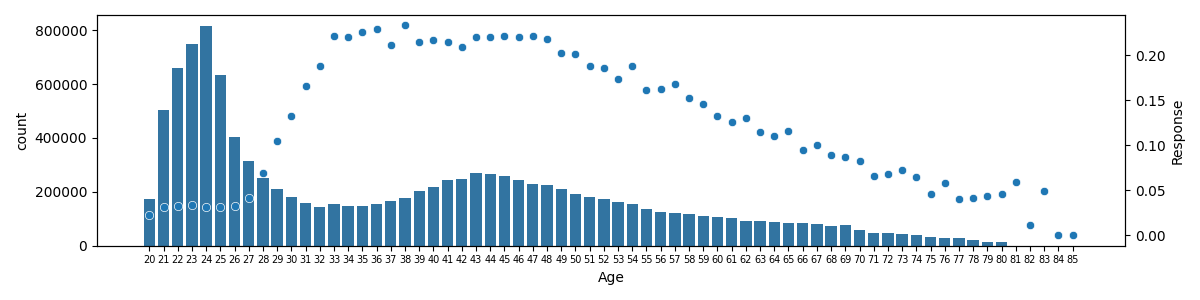

In [14]:
sc.cache_fig(
    'hist_age', lambda x: bar_scatter_Age(x, np.ones_like(df_train[target]) == 1), figsize=(12, 3)
)

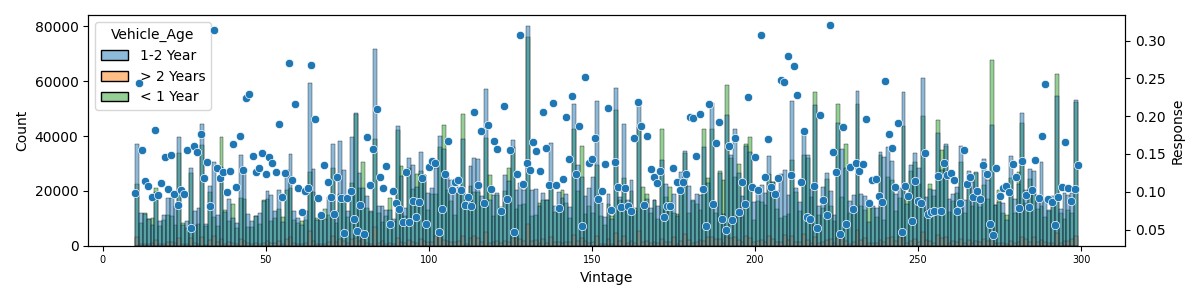

In [15]:
def hist_scatter_Vintage(ax):
    ax.tick_params(axis='x', labelsize=7)
    sns.histplot(df_train, x='Vintage', hue='Vehicle_Age', ax=ax)
    sns.scatterplot(df_train.groupby('Vintage', observed=True)[target].mean(), ax=ax.twinx())
sc.cache_fig(
    'hist_Vintage', lambda x: hist_scatter_Vintage(x), figsize=(12, 3)
)

In [16]:
from scipy.stats import mannwhitneyu
(
    mannwhitneyu(
        df_train.loc[df_train[target] == 0, 'Vintage'],
        df_train.loc[df_train[target] == 1, 'Vintage']
    ), df_train.loc[df_train[target] == 0, 'Vintage'].median()
    , df_train.loc[df_train[target] == 1, 'Vintage'].median()
)

(MannwhitneyuResult(statistic=np.float64(7326595875460.0), pvalue=np.float64(0.0)),
 np.float64(167.0),
 np.float64(164.0))

In [17]:
# Vintage의 수치별 뚜렷한 경향성은 파악하기 어렵습니다. 범주형식일 가능성이 높아 보입니다.
df_train.groupby('Vintage')[target].mean().to_frame().join(df_train['Vintage'].value_counts().rename('cnt'))\
    .sort_values('cnt')

,Response,cnt
Vintage,,
50,0.123482,14002
41,0.105736,15359
32,0.139069,15460
26,0.155111,16182
25,0.096752,16289
...,...,...
232,0.126892,85183
256,0.121084,90945
131,0.128727,91892


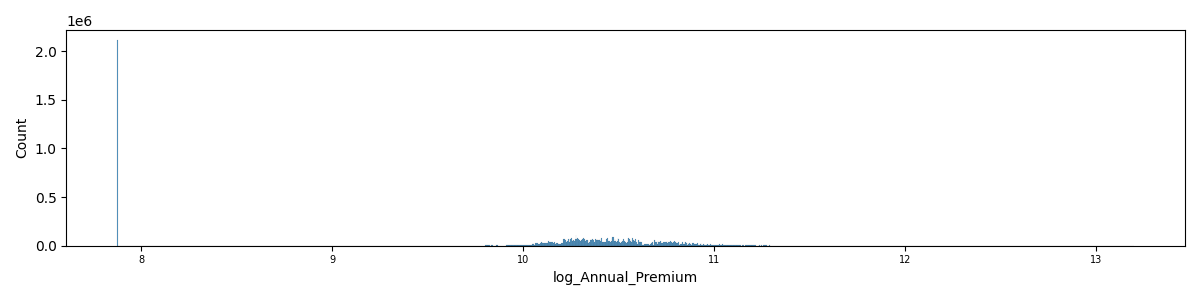

In [18]:
sc.cache_fig(
    'hist_Annual_Premium', lambda x: sns.histplot(np.log(df_train['Annual_Premium']).rename('log_Annual_Premium'), ax=x.tick_params(axis='x', labelsize=7)), 
    figsize=(12, 3)
)

In [19]:
df_train.loc[df_train['Annual_Premium'] < 5000, 'Annual_Premium'].value_counts()

Annual_Premium
2630.0    2112561
2730.0         10
2909.0          6
4023.0          5
3972.0          5
           ...   
2820.0          1
3426.0          1
3948.0          1
2789.0          1
4570.0          1
Name: count, Length: 202, dtype: int64

In [20]:
df_train['Annual_Premium'].describe()

count    1.150480e+07
mean     3.046136e+04
std      1.645474e+04
min      2.630000e+03
25%      2.527700e+04
50%      3.182400e+04
75%      3.945100e+04
max      5.401650e+05
Name: Annual_Premium, dtype: float64

2630이 가장 빈도수가 높고, 작은수 입니다.

Annual_Premium이 2630인 여부를 체크하는 변수를 만들고,

자연로그 변환 후에 2630인 경우를 제외하고 평균의 값으로 2630인 경우를 치환하는 변환을 만들어 모수적 모델에서 사용하게 합니다.

## Chi2 test of all categorical variables and quantized Continuous Variables

In [21]:
qval = [-np.inf] + df_train['Annual_Premium'].mode().tolist() + \
    df_train.loc[df_train['Annual_Premium'] > df_train['Annual_Premium'].mode()[0], 'Annual_Premium'].quantile(np.arange(10, 101, 10) / 100).tolist()
qval[-1] = np.inf
df_train['Annual_Premium_q'] =  pd.cut(df_train['Annual_Premium'], bins=qval, duplicates='drop')
df_train['Age_q'] = pd.qcut(df_train['Age'], q=8, duplicates='drop')
df_train['Vintage_q'] = pd.qcut(df_train['Vintage'], q=10, duplicates='drop')

In [22]:
from itertools import combinations
from scipy.stats import chi2_contingency
def get_chi2():
    chi2_list = list()
    for a, b in combinations(X_cat + ['Vintage_q', 'Annual_Premium_q', 'Age_q'], 2):
        chi2_result = chi2_contingency(df_train.pivot_table(index=a, columns=b, aggfunc='size', observed=True, fill_value=0))
        chi2_list.append(pd.Series([chi2_result[0], chi2_result[1]], index=['stat', 'pvalue'], name=(a, b)))
    return pd.DataFrame(chi2_list)
df_chi2 = sc.cache_result('chi2_test', get_chi2)

In [23]:
df_chi2.sort_values('stat', ascending=False)

,,stat,pvalue
Region_Code,Policy_Sales_Channel,1.386374e+07,0.0
Vehicle_Age,Age_q,9.554655e+06,0.0
Policy_Sales_Channel,Age_q,9.062827e+06,0.0
Vehicle_Age,Policy_Sales_Channel,9.005584e+06,0.0
Previously_Insured,Vehicle_Damage,8.044762e+06,0.0
Region_Code,Annual_Premium_q,5.194048e+06,0.0
Policy_Sales_Channel,Annual_Premium_q,2.951279e+06,0.0
Vehicle_Damage,Policy_Sales_Channel,2.515800e+06,0.0
Previously_Insured,Policy_Sales_Channel,2.395580e+06,0.0
Region_Code,Age_q,2.171015e+06,0.0


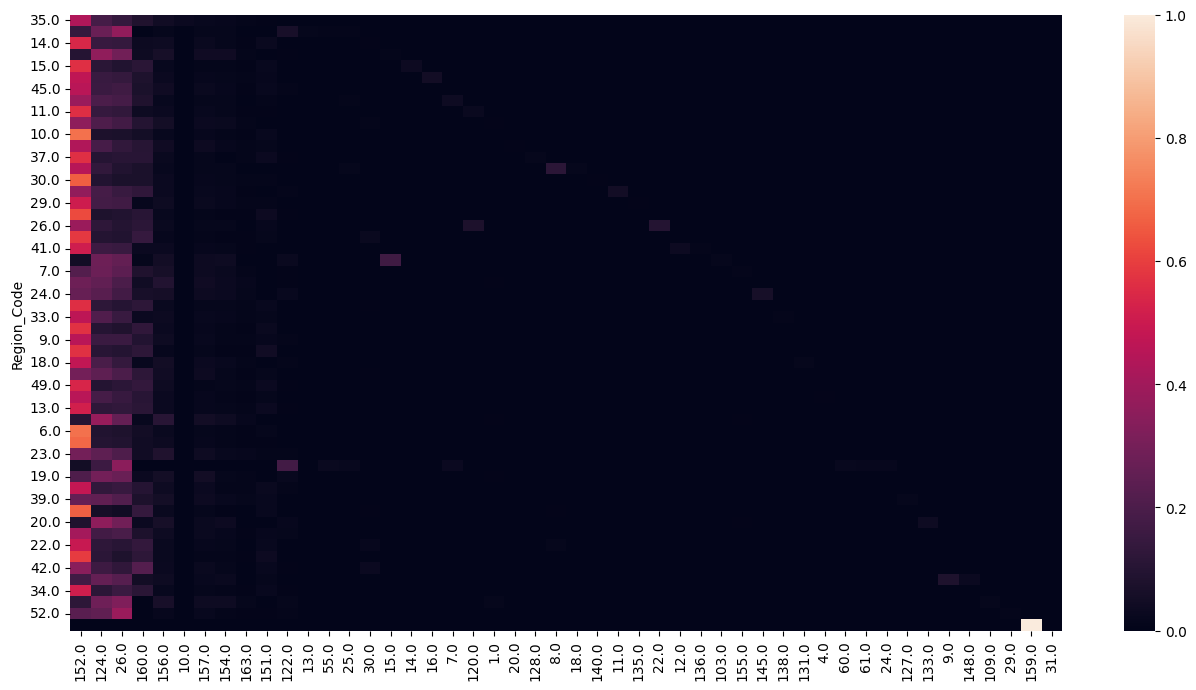

In [24]:
plt.figure(figsize=(16, 8))
sns.heatmap(
    df_train.groupby('Region_Code', observed=True)['Policy_Sales_Channel'].apply(lambda x: x.value_counts(normalize=True).iloc[:10]).unstack(level=-1).fillna(0)
)
plt.show()

In [25]:
df_train.groupby(['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age'], observed=False)['Response'].agg(['sum', 'count', 'mean'])

sum    count      mean
Vehicle_Damage Previously_Insured Vehicle_Age                            
Yes            0                  1-2 Year     1047325  3710363  0.282270
                                  > 2 Years     142909   476450  0.299945
                                  < 1 Year      198983  1317289  0.151055
               1                  1-2 Year        1181   163491  0.007224
                                  > 2 Years         11     1048  0.010496
                                  < 1 Year         629   114588  0.005489
No             0                  1-2 Year       13765   354693  0.038808
                                  > 2 Years         18      281  0.064057
                                  < 1 Year        8659   319040  0.027141
               1                  1-2 Year        1001  1754131  0.000571
                                  > 2 Years          0      196  0.000000
                                  < 1 Year         578  3293228  0.000176

Vehicle_Damage, Previously_Insured 그리고 Vehicle_Age 으로도 target을 어느 정도 구분해낼 수 있습니다.

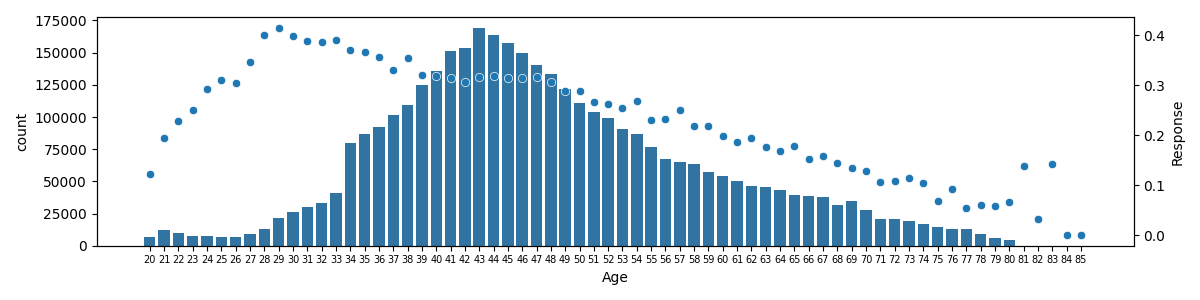

In [26]:
sc.cache_fig(
    'hist_age_y_0_12', lambda x: bar_scatter_Age(
        x, (df_train[['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age']] == ['Yes', '0', '1-2 Year']).all(axis=1)
    ), figsize=(12, 3)
)

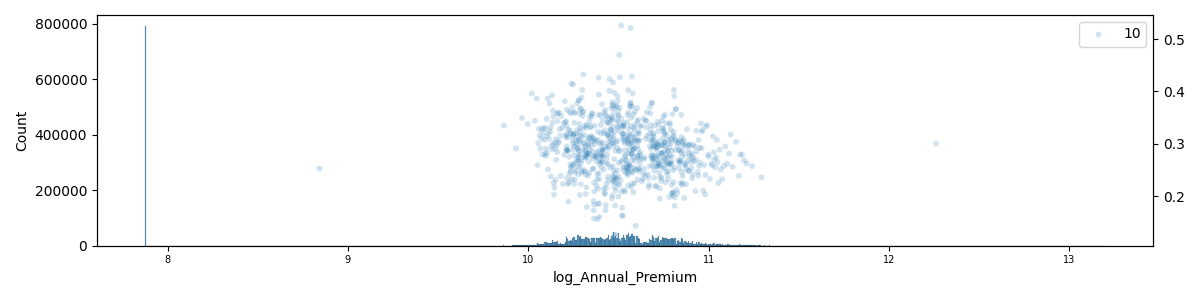

In [27]:
sc.cache_fig(
    'hist_Annual_y_0_12', lambda x: hist_scatter_log_Annual_Premium_plot(
        x, (df_train[['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age']] == ['Yes', '0', '1-2 Year']).all(axis=1)
    ), figsize=(12, 3)
)

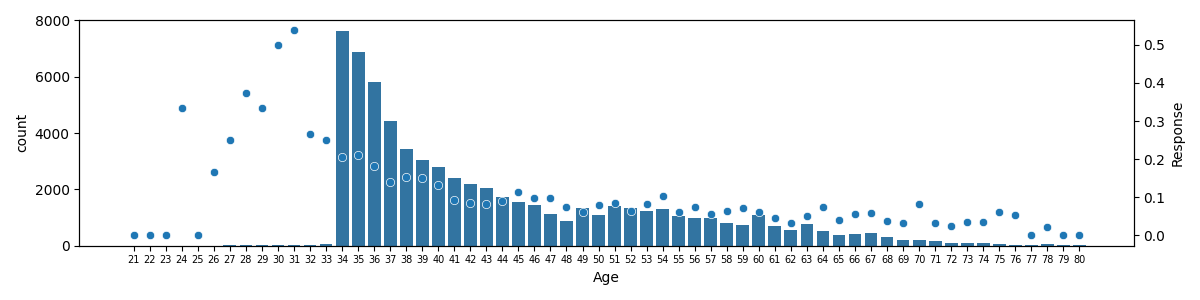

In [28]:
sc.cache_fig(
    'hist_age_y_0_12_152', lambda x: bar_scatter_Age(
        x, (df_train[['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Policy_Sales_Channel']] == ['Yes', '0', '1-2 Year', '152.0']).all(axis=1)), 
    figsize=(12, 3)
)

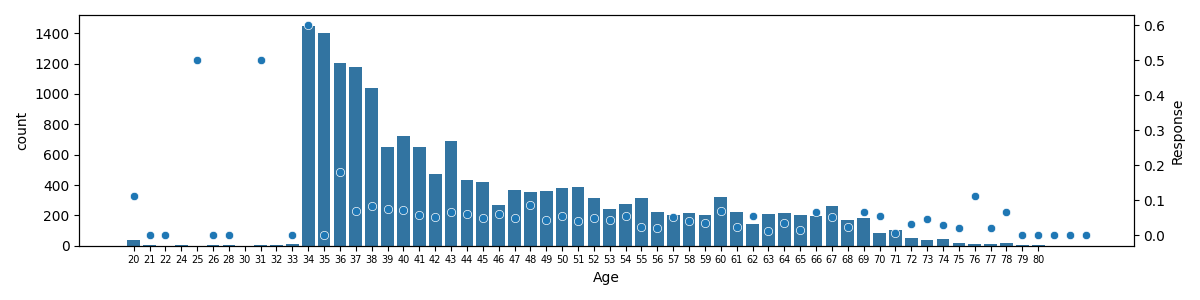

In [29]:
sc.cache_fig(
    'hist_age_y_0_12_160', lambda x: bar_scatter_Age(
        x, (df_train[['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Policy_Sales_Channel']] == ['Yes', '0', '1-2 Year', '160.0']).all(axis=1)), 
    figsize=(12, 3)
)

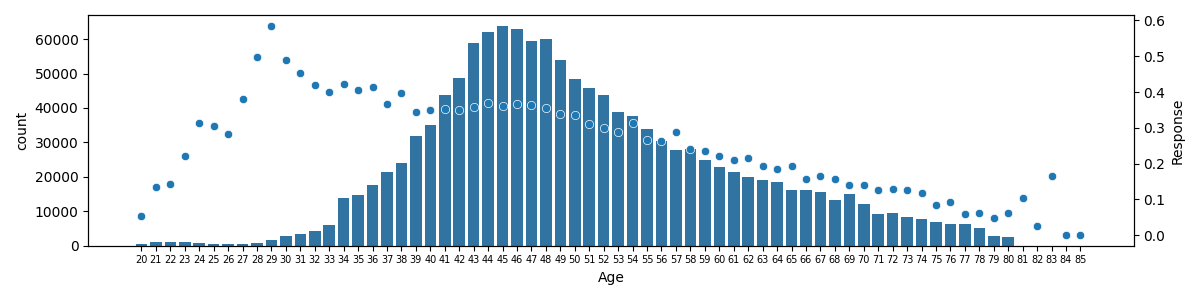

In [30]:
sc.cache_fig(
    'hist_age_y_0_12_26', lambda x: bar_scatter_Age(
        x, (df_train[['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Policy_Sales_Channel']] == ['Yes', '0', '1-2 Year', '26.0']).all(axis=1)), 
    figsize=(12, 3)
)

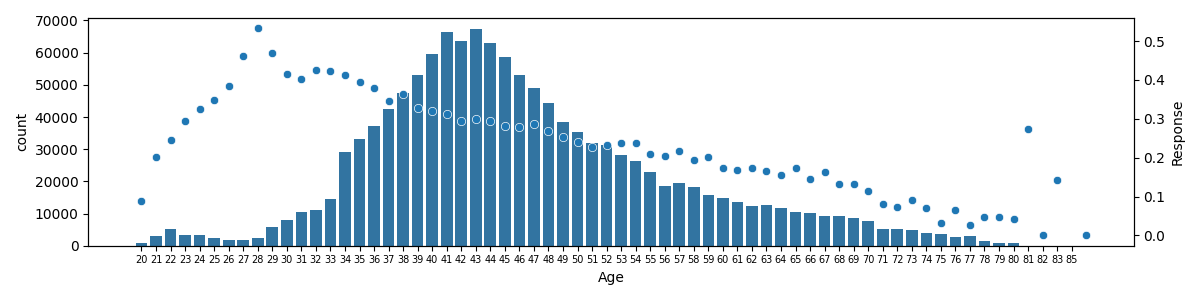

In [31]:
sc.cache_fig(
    'hist_age_y_0_12_124', lambda x: bar_scatter_Age(
        x, (df_train[['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Policy_Sales_Channel']] == ['Yes', '0', '1-2 Year', '124.0']).all(axis=1)), 
    figsize=(12, 3)
)

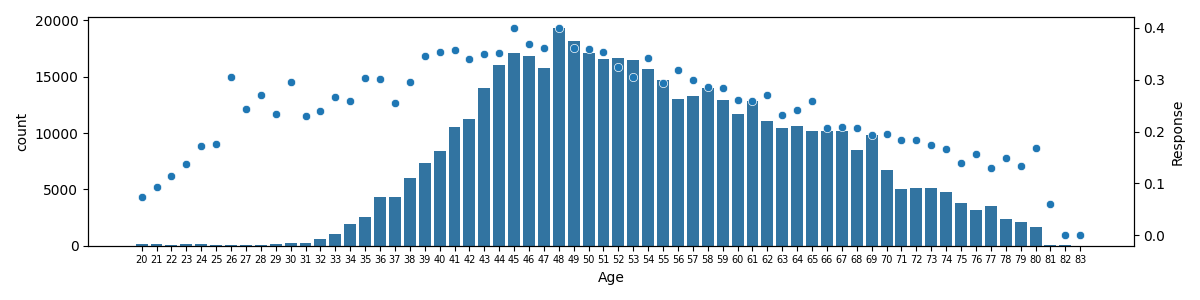

In [32]:
sc.cache_fig(
    'hist_age_y_0_2', lambda x: bar_scatter_Age(
        x, (df_train[['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age']] == ['Yes', '0', '> 2 Years']).all(axis=1)
    ), figsize=(12, 3)
)

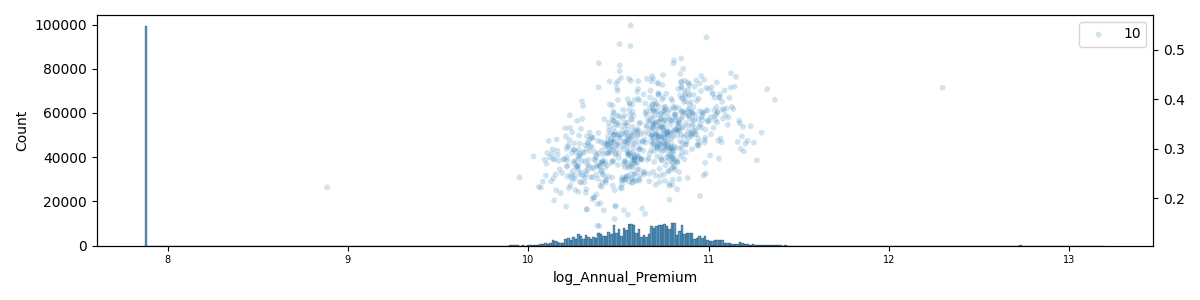

In [33]:
sc.cache_fig(
    'hist_Annual_y_0_2', lambda x: hist_scatter_log_Annual_Premium_plot(
        x, (df_train[['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age']] == ['Yes', '0', '> 2 Years']).all(axis=1)
    ), figsize=(12, 3)
)

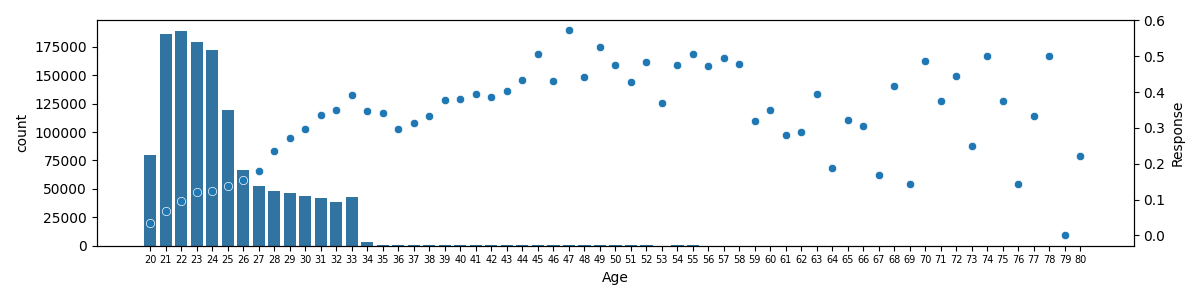

In [34]:
sc.cache_fig(
    'hist_age_y_0_1', lambda x: bar_scatter_Age(
        x, (df_train[['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age']] == ['Yes', '0', '< 1 Year']).all(axis=1)
    ), figsize=(12, 3)
)

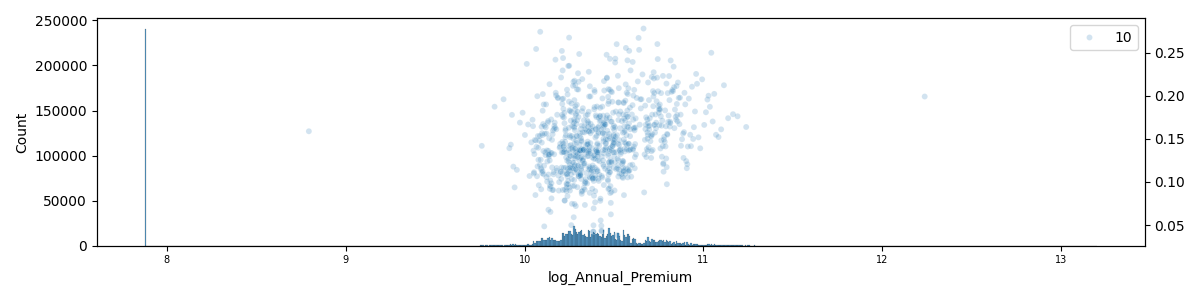

In [35]:
sc.cache_fig(
    'hist_Annual_y_0_1', lambda x: hist_scatter_log_Annual_Premium_plot(
        x, (df_train[['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age']] == ['Yes', '0', '< 1 Year']).all(axis=1)
    ), figsize=(12, 3)
)

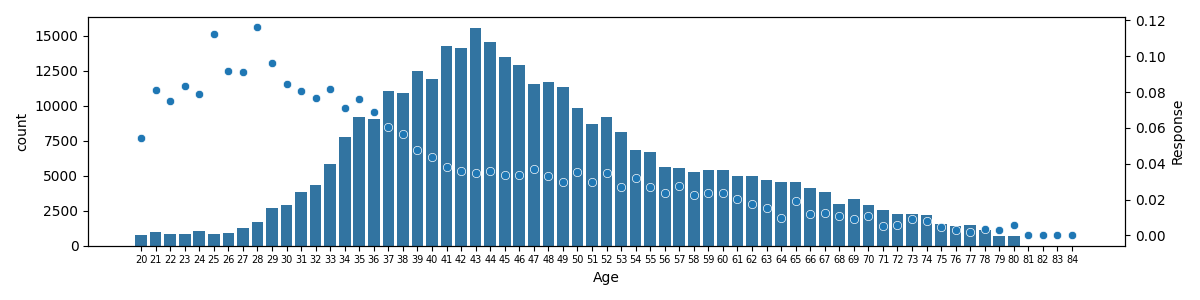

In [36]:
sc.cache_fig(
    'hist_age_n_0_12', lambda x: bar_scatter_Age(
        x, (df_train[['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age']] == ['No', '0', '1-2 Year']).all(axis=1)
    ), figsize=(12, 3)
)

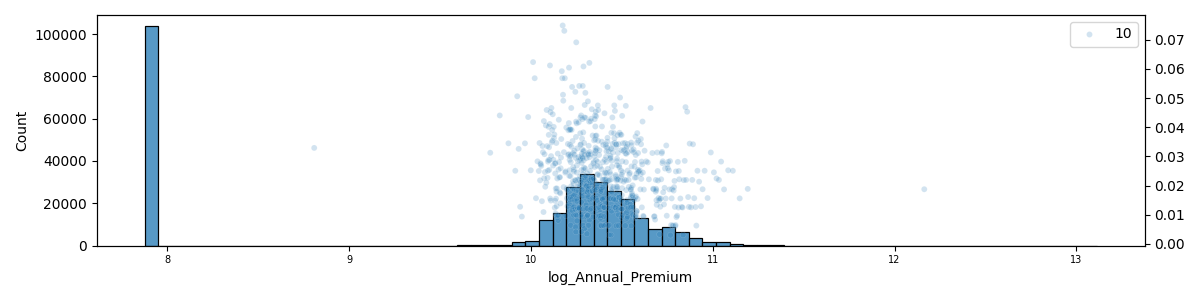

In [37]:
sc.cache_fig(
    'hist_Annual_n_1_1', lambda x: hist_scatter_log_Annual_Premium_plot(
        x, (df_train[['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age']] == ['No', '1', '< 1 Year']).all(axis=1)
    ), figsize=(12, 3)
)

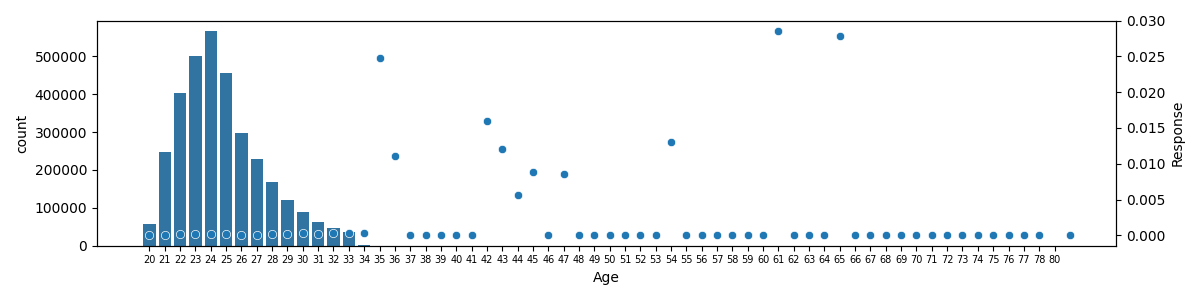

In [38]:
sc.cache_fig(
    'hist_age_n_1_1', lambda x: bar_scatter_Age(
        x, (df_train[['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age']] == ['No', '1', '< 1 Year']).all(axis=1)
    ), figsize=(12, 3)
)

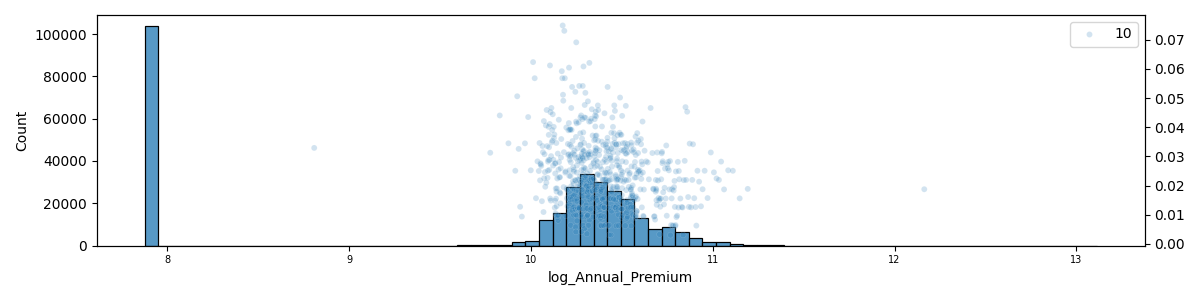

In [39]:
sc.cache_fig(
    'hist_Annual_n_1_1', lambda x: hist_scatter_log_Annual_Premium_plot(
        x, (df_train[['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age']] == ['No', '0', '< 1 Year']).all(axis=1)
    ), figsize=(12, 3)
)

Chi2 테스트와 여러 시각화로 확인한 결과, 변수간의 상관성이 큽니다.  변수가의 상관성을 고려하여 이들을 결합하여 효과적으로 표현할 수 있지 않을가 생각을 해봅니다,

In [40]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

ss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=123)
from sklearn.metrics import roc_auc_score

def grp_target_encoding(X_grp, cv):
    valid_scores, train_scores = list(), list()
    for train_idx, valid_idx in cv.split(df_train, df_train[target]):
        df_cv_train, df_valid = df_train.iloc[train_idx], df_train.iloc[valid_idx]
        target_mean = df_cv_train[target].mean()
        s_mean = df_cv_train.groupby(X_grp, observed=True)[target].mean()
        valid_scores.append(
            roc_auc_score(df_valid[target], df_valid[X_grp].join(s_mean, on=X_grp)[target].fillna(target_mean))
        )
        train_scores.append(
            roc_auc_score(df_cv_train[target], df_cv_train[X_grp].join(s_mean, on=X_grp)[target].fillna(target_mean))
        )
    return valid_scores, train_scores, len(s_mean)

[\[AutoML Grand Prix\] 1st Place Solution](https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution)

CatBoost에서 이 데이터셋을 연속형 변수의 형태를 보이는 변수인 Annual_Premium, Vintage, Age를 범주형으로 만들었을 때 성능이 좋았습니다.

CatBoost는 범주형 변수의 범주수가 일정 수준 이상(Default 100)을 넘을 경우 Target Encoding을 하도록 되어 있고,

범주형 변수들을 결합한 속성을 만들어주는 기능이 기본적으로 작동합니다.

여러 실험을 했지만 LightGBM, XGBoost의 성능은 CatBoost의 성능에 미치지 못했는데요, 바로 CatBoost의 CatBoost의 범주형 변수 처리 방식의 차이 때문이었습니다.

이 데이터셋은 Vehicle_Damage와 Previously_Insured가 Target을 구분하는데 키 변수이고 범주형 변수입니다. 

이들과 여러 변수들을 결합하여 범주형 변수를 만들어 Target Encoding을 하여 성능을 측정했을 때 좋았던 성능을 보인 4개의 경우를 

찾았고, 이들을 이용하여 로지스틱 회귀 모델을 만들게 되면 상당한 성능 향상을 보입니다.

특히, 의외였던 것은 Annual Premium은 카디널리티가 상대적으로 커서 처음에는 구간화를 통해 카디널리티를 낮추었을 때보다는,

전혀 구간화를 하지않고 그냥 범주형 변수로 만들었을 때의 성능이 향상폭이 높았습니다.

Target에 대한 이러한 점에서 입력 변수들의 상호작용이 강하다라는 것을 알 수 있습니다.

또한 이러한 범주형 변수의 결합은 상관성이 크기 때문에 이들을 결합을 통해 패턴을 나타내는데, 효과적일 수 있습니다.

In [41]:
df_s_cat = sc.cache_result(
    'tgt_single_cat',
    lambda : pd.DataFrame({k: pd.Series(grp_target_encoding([k], ss), index=['valid', 'train', 'n_unique']) for k in X_cat})
).T.map(lambda x: np.mean(x)).sort_values('valid', ascending=False)
df_s_cat

,valid,train,n_unique
Vehicle_Damage,0.773771,0.773877,2.0
Previously_Insured,0.762467,0.762628,2.0
Policy_Sales_Channel,0.719840,0.719945,152.0
Age_c,0.708053,0.708483,66.0
Annual_Premium_c,0.700623,0.711769,34945.0
Vehicle_Age,0.678279,0.677891,3.0
Vintage_c,0.639361,0.639522,290.0
Region_Code,0.625488,0.625846,54.0
Gender,0.541494,0.541980,2.0


In [42]:
from itertools import combinations
df_two_cat = sc.cache_result(
    'tgt_two_cat',
    lambda : pd.DataFrame(
        {(a, b): pd.Series(grp_target_encoding([a, b], ss), index=['valid', 'train', 'n_unique']) for a, b in combinations(X_cat, 2)}
    )
).T.map(lambda x: np.mean(x)).sort_values('valid', ascending=False)
df_two_cat

valid     train   n_unique
Vehicle_Damage       Annual_Premium_c      0.836959  0.846708    69782.0
                     Age_c                 0.834717  0.835010      132.0
Previously_Insured   Annual_Premium_c      0.832462  0.841016    69792.0
Vehicle_Damage       Vintage_c             0.828638  0.829074      580.0
Previously_Insured   Age_c                 0.827793  0.828140      132.0
Vehicle_Damage       Policy_Sales_Channel  0.824122  0.824503      297.0
Previously_Insured   Vintage_c             0.822095  0.822427      580.0
                     Policy_Sales_Channel  0.820452  0.820848      298.0
Region_Code          Vehicle_Damage        0.810086  0.810208      107.0
Vehicle_Age          Vehicle_Damage        0.806150  0.806245        6.0
Region_Code          Previously_Insured    0.805359  0.805546      107.0
Previously_Insured   Vehicle_Age           0.801289  0.801400        6.0
                     Vehicle_Damage        0.791217  0.791405        4.0
Gender               Vehicle_Damage        0.781313  0.781671        4.0
                     Previously_Insured    0.772379  0.772816        4.0
Policy_Sales_Channel Vintage_c             0.767972  0.774021    27357.0
                     Annual_Premium_c      0.767430  0.827442   414618.0
                     Age_c                 0.760641  0.762037     6334.0
Vehicle_Age          Annual_Premium_c      0.756017  0.777882    97018.0
Age_c                Vintage_c             0.750865  0.755999    18029.0
Region_Code          Policy_Sales_Channel  0.743124  0.743959     3718.0
Vehicle_Age          Vintage_c             0.739761  0.739837      870.0
                     Policy_Sales_Channel  0.737190  0.737446      377.0
Region_Code          Age_c                 0.729980  0.731250     3313.0
Vehicle_Age          Age_c                 0.729242  0.728868      190.0
Gender               Policy_Sales_Channel  0.722067  0.722236      300.0
Region_Code          Annual_Premium_c      0.718146  0.796484   582865.0
Gender               Age_c                 0.710693  0.711219      131.0
Region_Code          Vehicle_Age           0.709533  0.709158      160.0
Gender               Annual_Premium_c      0.701642  0.721978    69890.0
Annual_Premium_c     Age_c                 0.701041  0.869499  1213650.0
Region_Code          Vintage_c             0.683914  0.690150    15365.0
Gender               Vehicle_Age           0.683011  0.682691        6.0
                     Vintage_c             0.646562  0.647017      580.0
                     Region_Code           0.636451  0.637059      107.0
Annual_Premium_c     Vintage_c             0.624424  0.931475  3376726.0

In [43]:
X_cat2 = [i for i in X_cat if i not in ['Vehicle_Damage', 'Previously_Insured']]
df_vp_single_cat = sc.cache_result(
    'tgt_VP_single_cat',
    lambda : pd.DataFrame(
        {k: pd.Series(grp_target_encoding(['Vehicle_Damage', 'Previously_Insured', k], ss), index=['valid', 'train', 'n_unique']) for k in X_cat2}
    )
).T.map(lambda x: np.mean(x)).sort_values('valid', ascending=False)
df_vp_single_cat

,valid,train,n_unique
Annual_Premium_c,0.846130,0.856782,128842.0
Age_c,0.844999,0.845382,261.0
Vintage_c,0.841153,0.841695,1160.0
Policy_Sales_Channel,0.834991,0.835447,555.0
Region_Code,0.823684,0.823653,213.0
Vehicle_Age,0.818162,0.818361,12.0
Gender,0.798232,0.798688,8.0


In [44]:
X_cat2 = [i for i in X_cat if i not in ['Vehicle_Damage', 'Vehicle_Age']]
df_vp_single_cat = sc.cache_result(
    'tgt_VV_single_cat',
    lambda : pd.DataFrame(
        {k: pd.Series(grp_target_encoding(['Vehicle_Damage', 'Vehicle_Age', k], ss), index=['valid', 'train', 'n_unique']) for k in X_cat2}
    )
).T.map(lambda x: np.mean(x)).sort_values('valid', ascending=False)
df_vp_single_cat

,valid,train,n_unique
Vintage_c,0.841779,0.842422,1646.0
Annual_Premium_c,0.840202,0.862369,163833.0
Age_c,0.838419,0.838520,371.0
Policy_Sales_Channel,0.829933,0.830410,625.0
Region_Code,0.821544,0.821346,307.0
Previously_Insured,0.818162,0.818361,12.0
Gender,0.807762,0.808030,12.0


In [45]:
df_vp_two_cat = sc.cache_result(
    'tgt_VP_two_cat',
    lambda : pd.DataFrame({
        (a, b): pd.Series(grp_target_encoding(['Vehicle_Damage', 'Previously_Insured', a, b], ss), index=['valid', 'train', 'n_unique'])
        for a, b in combinations(X_cat2, 2)
    })
).T.map(lambda x: np.mean(x)).sort_values('valid', ascending=False)
df_vp_two_cat

valid     train   n_unique
Age_c                Vintage_c             0.862891  0.869041    70565.0
Policy_Sales_Channel Vintage_c             0.858161  0.864971    69756.0
                     Age_c                 0.856997  0.858817    17998.0
Vehicle_Age          Vintage_c             0.851816  0.852610     3120.0
Region_Code          Age_c                 0.851801  0.853194    12902.0
                     Vintage_c             0.848699  0.854431    59666.0
Vehicle_Age          Annual_Premium_c      0.848040  0.870953   256758.0
                     Age_c                 0.848004  0.848233      703.0
Gender               Age_c                 0.845341  0.845881      518.0
Region_Code          Policy_Sales_Channel  0.843742  0.844820     9951.0
Gender               Annual_Premium_c      0.842428  0.861440   237506.0
                     Vintage_c             0.841713  0.842483     2320.0
Policy_Sales_Channel Annual_Premium_c      0.840455  0.893997   750702.0
Vehicle_Age          Policy_Sales_Channel  0.840255  0.840787     1034.0
Gender               Policy_Sales_Channel  0.835561  0.835983     1059.0
Region_Code          Vehicle_Age           0.832600  0.832462      593.0
                     Annual_Premium_c      0.826308  0.893251  1077006.0
Gender               Region_Code           0.824979  0.825091      425.0
                     Vehicle_Age           0.819401  0.819925       24.0
Annual_Premium_c     Age_c                 0.783439  0.929996  2036634.0
                     Vintage_c             0.703932  0.968578  4471301.0

In [46]:
X_cat2 = [i for i in X_cat if i not in ['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age']]
df_v2p_single_cat = sc.cache_result(
    'tgt_V2P_single_cat',
    lambda : pd.DataFrame({
        k: pd.Series(grp_target_encoding(['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', k], ss), index=['valid', 'train', 'n_unique']) 
        for k in X_cat2
    })
).T.map(lambda x: np.mean(x)).sort_values('valid', ascending=False)
df_v2p_single_cat

,valid,train,n_unique
Vintage_c,0.851816,0.852610,3120.0
Annual_Premium_c,0.848040,0.870953,256758.0
Age_c,0.848004,0.848233,703.0
Policy_Sales_Channel,0.840255,0.840787,1034.0
Region_Code,0.832600,0.832462,593.0
Gender,0.819401,0.819925,24.0


In [47]:
X_cat2 = [i for i in X_cat if i not in ['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Gender']]
df_v2pg_single_cat = sc.cache_result(
    'tgt_V2PG_single_cat',
    lambda : pd.DataFrame(
        {k: pd.Series(grp_target_encoding(['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Gender', k], ss), index=['valid', 'train', 'n_unique']) for k in X_cat2}
    )
).T.map(lambda x: np.mean(x)).sort_values('valid', ascending=False)
df_v2pg_single_cat

,valid,train,n_unique
Vintage_c,0.852095,0.853291,5920.0
Age_c,0.848294,0.848761,1335.0
Policy_Sales_Channel,0.840816,0.841492,1878.0
Annual_Premium_c,0.839197,0.877944,450146.0
Region_Code,0.832992,0.833156,1146.0


In [48]:
X_cat2 = [i for i in X_cat if i not in ['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Gender', 'Age_c']]
df_v2pga_single_cat = sc.cache_result(
    'tgt_V2PGA_single_cat',
    lambda : pd.DataFrame(
        {k: pd.Series(grp_target_encoding(['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Gender', 'Age_c'] + [k], ss), index=['valid', 'train', 'n_unique']) for k in X_cat2}
    )
).T.map(lambda x: x[0]).sort_values('valid', ascending=False)
df_v2pga_single_cat

,valid,train,n_unique
Policy_Sales_Channel,0.858047,0.862492,40523
Vintage_c,0.856933,0.876790,209911
Region_Code,0.852448,0.857325,42373
Annual_Premium_c,0.750318,0.953232,2999640


In [49]:
X_cat2 = [i for i in X_cat if i not in ['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Gender', 'Age_c', 'Region_Code']]
df_v2p2gr_single_cat = sc.cache_result(
    'tgt_V2P2GR_single_cat',
    lambda : pd.DataFrame(
        {k: pd.Series(grp_target_encoding(['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Gender', 'Age_c', 'Region_Code'] + [k], ss), index=['valid', 'train', 'n_unique']) for k in X_cat2}
    )
).T.map(lambda x: x[0]).sort_values('valid', ascending=False)
df_v2p2gr_single_cat

,valid,train,n_unique
Policy_Sales_Channel,0.849212,0.876148,295358
Vintage_c,0.780380,0.936308,2354649
Annual_Premium_c,0.705226,0.976241,5100938


# Machine Learning

## Logistic Regression

In [50]:
from sklearn.preprocessing import TargetEncoder, OneHotEncoder
from sklearn.model_selection import cross_validate, train_test_split

def predict(m, df_valid, X):
    return pd.Series(m.predict_proba(df_valid[X])[:, 1], index=df_valid.index)

def eval_metric(y_true, prds):
    return roc_auc_score(y_true[target].sort_index(), prds.sort_index())

In [51]:
from sklearn.linear_model import LogisticRegression


X_tgt = ['VPVA', 'VAge', 'PA', 'VV', 'PAge', 'VP', 'PVc', 'PP', 'RV', 'RP',  'VPPV', 'VPPA', 'VPVGAP', 'VPVGAV', 'VPVGAR', 'VPRV', 'VPAV', 'AA', 'AV', 'VPPAc', 'VPRAc']
X_ohe = ['Driving_License']
clf_lr = make_pipeline(
    ColumnTransformer([
        ('tgt', TargetEncoder(), X_tgt), 
        ('ohe', OneHotEncoder(drop='first'), X_ohe)
    ]),
    LogisticRegression()
)
sc.cache_result(
    'lr_tgt_ss',
    lambda : cross_validate(
        clf_lr, df_train[X_tgt + X_ohe], df_train[target], cv = ss, scoring='roc_auc', return_train_score=True
    )
)

{'fit_time': array([118.12455654]),
 'score_time': array([26.74961662]),
 'test_score': array([0.88862178]),
 'train_score': array([0.90809065])}

변수 그대로를 사용하여 학습을 해봅니다.

## LightGBM

In [52]:
X_lgb_cat = ['Driving_License', 'Vehicle_Age', 'Gender', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured', 'Vehicle_Damage']
X_lgb_num = ['Age', 'Annual_Premium', 'Vintage']
X_lgb = X_lgb_cat + X_lgb_num
train_metrics, valid_metrics, s_prd, model_result_cv = sc.cache_result(
    'lgbm_baseline',
    lambda : sgml.cv_model(
        ss, lgb.LGBMClassifier, 
        {'verbose': -1, 'num_leaves': 255, 'n_estimators': 2000, 'learning_rate': 0.01}, 
        df_train, X_lgb, target, predict, eval_metric, 
        result_proc=sgml.lgb_learning_result, 
        train_params={
            'fit_params': {
                'categorical_feature': X_lgb_cat, 'eval_metric': 'auc', 
            },
            'valid_splitter': lambda x: train_test_split(x, train_size=0.9, stratify=x[target], random_state=123),
            'valid_config_proc': sgml.gb_valid_config
        })
)
train_metrics, valid_metrics

([np.float64(0.8856978673747513)], [np.float64(0.8804012329465636)])

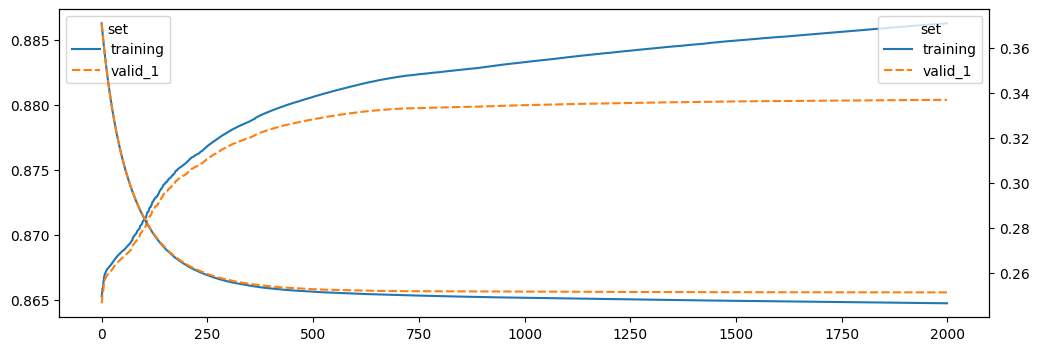

In [53]:
plt.figure(figsize=(12, 4))
sns.lineplot(
    model_result_cv[0][0]['auc']
)
sns.lineplot(
    model_result_cv[0][0]['binary_logloss'], ax=plt.gca().twinx()
)
plt.show()

In [54]:
model_result_cv[0][0]['auc']['training'].max(), model_result_cv[0][0]['auc']['valid_1'].max()

(np.float64(0.8862864892635773), np.float64(0.8803879314081845))

In [ ]:
model_result_cv[0][1].sort_values(ascending=False).pipe(lambda x: sns.barplot(x=x.values, y = x.index.values))
plt.show()

변수 결합과 Target Encoding을 통한 방법을 적용해봅니다.

Target Encoding은 보다 효과적으로 범주형 변수의 패턴을 나타낼 수 있었고, 보다 높은 학습 정확도와 검증 정확도를 얻을 수 있었습니다.

In [56]:
X_lgb_tgt = ['VPVA', 'VAge', 'PA', 'VV', 'PAge', 'VP', 'PVc', 'PP', 'RV', 'RP',  'VPPV', 'VPPA', 'VPVGAP', 'VPVGAV', 'VPVGAR', 'VPRV', 'VPAV', 'AA', 'AV', 'VPPAc', 'VPRAc']
X_lgb_cat = ['V2V', 'PV2', 'PV', 'GV2', 'GP', 'Driving_License', 'Vehicle_Age', 'Gender', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured', 'Vehicle_Damage', 'Age_c', 'Vintage_c']
X_lgb_num = ['Annual_Premium', 'Age']
X_lgb = X_lgb_tgt + X_lgb_cat + X_lgb_num
train_metrics, valid_metrics, s_prd, model_result_cv =  sc.cache_result(
    'lgbm_pilot',
    lambda : sgml.cv_model(
        ss, lgb.LGBMClassifier, 
        {'verbose': -1, 'num_leaves': 255, 'n_estimators': 3000, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'min_child_samples': 16}, 
        df_train, X_lgb, target, predict, eval_metric,
        preprocessor=ColumnTransformer([
            ('tgt', TargetEncoder(), X_lgb_tgt),
            ('pt', 'passthrough', X_lgb_cat + X_lgb_num)
        ]).set_output(transform="pandas"), 
        result_proc=sgml.lgb_learning_result, 
        train_params={
            'fit_params': {
                'categorical_feature': ['pt__' + i for i in X_lgb_cat], 'eval_metric': 'auc', 
                'callbacks': [sgml.LGBMFitProgressbar()]
            },
            'valid_splitter': lambda x: train_test_split(x, train_size=0.9, stratify=x[target], random_state=123),
            'valid_config_proc': sgml.gb_valid_config
        },
        return_train_scores=False
    ), rerun=True
)
train_metrics, valid_metrics

Round:   0%|          | 0/3000 [00:00<?, ?it/s]

([], [np.float64(0.8940307229694358)])

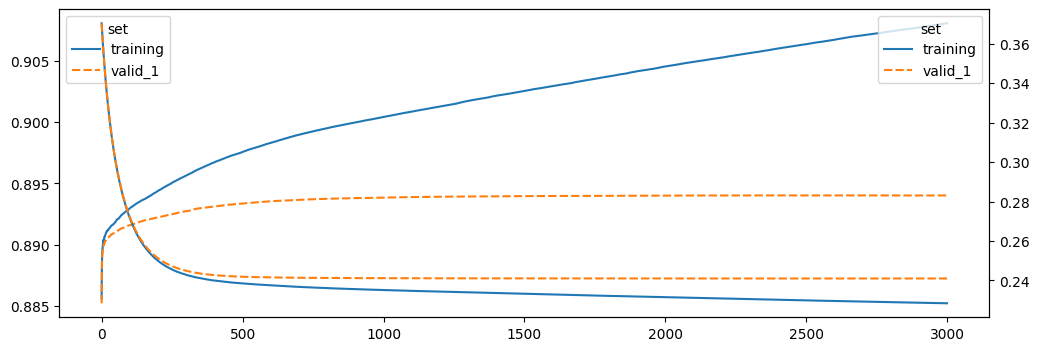

In [57]:
plt.figure(figsize=(12, 4))
sns.lineplot(
    model_result_cv[0][0]['auc']
)
sns.lineplot(
    model_result_cv[0][0]['binary_logloss'], ax=plt.gca().twinx()
)
plt.show()

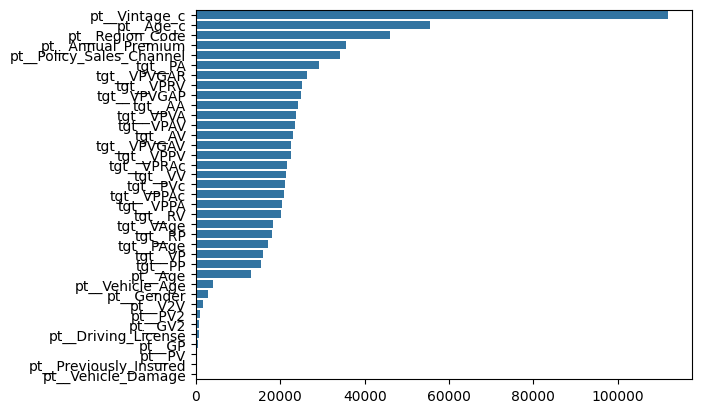

In [58]:
model_result_cv[0][1].sort_values(ascending=False).pipe(lambda x: sns.barplot(x=x.values, y = x.index.values))
plt.show()

## Neural Network

In [60]:
import tensorflow as tf
import sgnn

2024-10-28 01:20:16.648022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 01:20:16.777674: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 01:20:16.824630: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 01:20:17.057291: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 01:20:18.283943: W tensorflow/compiler/tf2

In [61]:
class ResponseModel(tf.keras.Model):
    def __init__(self, emb_cols, cont_cols, f_size, left_layers, right_layers, top_layers):
        super().__init__()
        if emb_cols != None:
            self.emb_layers = {
                v: tf.keras.layers.Embedding(c, s, name=v) for v, c, s in emb_cols
            }
            self.emb_cc = tf.keras.layers.Concatenate(axis=-1)
            if left_layers != None:
                self.left_model = tf.keras.models.Sequential([
                    tf.keras.layers.Dense(**params) for params in left_layers
                ])
                self.right_model = tf.keras.models.Sequential([
                    tf.keras.layers.Dense(**params) for params in right_layers
                ])
                self.mul = tf.keras.layers.Multiply()
                self.left_slice_layer_1 = tf.keras.layers.Lambda(lambda x: x[:, :f_size])
                self.left_slice_layer_2 = tf.keras.layers.Lambda(lambda x: x[:, f_size:])
                self.right_slice_layer_1 = tf.keras.layers.Lambda(lambda x: x[:, :f_size])
                self.right_slice_layer_2 = tf.keras.layers.Lambda(lambda x: x[:, f_size:])
            else:
                self.left_model = None
        else:
            self.emb_layers = None
        self.top_cc = tf.keras.layers.Concatenate(axis=-1)
        self.top_model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(**params) for params in top_layers
        ])
        self.f_size = f_size
        self.cont_cols = cont_cols
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def __call__(self, X):
        if self.emb_layers != None:
            X_emb = self.emb_cc([tf.squeeze(v(X[k]), axis=-2) for k, v in self.emb_layers.items()])
            if self.left_model !=None:
                X_left = self.left_model(X_emb)
                X_right = self.right_model(X_emb)
                X_left_1 = self.left_slice_layer_1(X_left)
                X_left_2 = self.left_slice_layer_2(X_left)
                
                X_right_1 = self.right_slice_layer_1(X_right)
                X_right_2 = self.right_slice_layer_2(X_right)
                X_mul = self.mul([X_left_1, X_right_1])
                cc_list = [X_left_2, X_right_2, X_mul]
            else:
                cc_list = [X_emb]
        else:
            cc_list = list()
        if self.cont_cols != None:
            cc_list.append(X[self.cont_cols])
        if len(cc_list) == 1:
            return self.sigmoid(
                self.top_model(cc_list[0])
            )
        else:
            return self.sigmoid(
                self.top_model(self.top_cc(cc_list))
            )

def to_tf_dataset(X, Y=None, sample_weights=None, cont=[], cat=[]):
    d = {}
    if len(cont) > 0:
        d['Continous'] =  X[cont].values
    for i in cat:
        d[i] = np.expand_dims(X[i].cat.codes, axis=-1)
    if Y is None:
        return tf.data.Dataset.from_tensor_slices(d)
    else:
        if type(Y) == pd.Series:
            if sample_weights is None:
                return tf.data.Dataset.from_tensor_slices((d, Y.values))
            else:
                return tf.data.Dataset.from_tensor_slices((d, Y.values, sample_weights.values))
        else:
            if sample_weights is None:
                return tf.data.Dataset.from_tensor_slices((d, Y))
            else:
                return tf.data.Dataset.from_tensor_slices((d, Y, sample_weights))

def nn_cat_param(df, name, size):
    return 'pt__' + name, len(df[name].cat.categories), size

def nn_cat_param2(df, name, size):
    return name, len(df[name].cat.categories), size

In [62]:
from sklearn.preprocessing import FunctionTransformer, StandardScaler
X_nn_tgt = ['VPVA', 'VAge', 'PA', 'VV', 'PAge', 'VP', 'PVc', 'PP', 'RV', 'RP',  'VPPV', 'VPPA', 'VPVGAP', 'VPVGAV', 'VPVGAR', 'VPRV', 'VPAV', 'AA', 'AV', 'VPPAc', 'VPRAc']
X_nn_emb = [
    ('V2V', 2), ('PV2', 2), ('PV', 2), ('GV2', 2), ('GP', 2), ('Vehicle_Age', 2), ('Gender', 1), ('Region_Code', 3), ('Policy_Sales_Channel', 3), 
    ('Previously_Insured', 2), ('Vehicle_Damage', 2), ('Age_c', 3), ('Vintage_c', 3)
]
X_nn_cat = [i for i, _ in X_nn_emb]
X_nn_num = ['Driving_License']
X_nn = X_nn_tgt + X_nn_cat + X_nn_num
nn_params = {
    'emb_cols': [
        nn_cat_param(df_train, v, n) for v, n in X_nn_emb
    ], 
    'cont_cols':  'Continous',
    'f_size':  16, 
    'left_layers': [
        {'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'units': 32, 'kernel_initializer': 'glorot_uniform'}]
    , 
    'right_layers': [
        {'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'units': 16, 'kernel_initializer': 'glorot_uniform'}
    ], 
    'top_layers': [
        {'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'units': 16, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'units': 1, 'kernel_initializer': 'glorot_uniform'}
    ]
}
train_metrics, valid_metrics, s_prd, model_result_cv = sc.cache_result(
    'nn_pilot2',
    lambda : sgml.cv_model(
        ss, sgnn.NNClassifier, 
        {
            'model': ResponseModel, 'model_params': nn_params,
            'to_tf_dataset': partial(to_tf_dataset, cont = ['tgt__' + i for i in X_nn_tgt], cat = ['pt__' + i for i in X_nn_cat]), 
            'optimizer': ('Adam', {'learning_rate': 5e-5}),
            'epochs': 5,
            'batch_size': 512, 'shuffle_size': 102400,
            'early_stopping': None, 'reduce_lr_on_plateau': None, 'lr_scheduler': None
        }, 
        df_train, X_nn, target, predict, eval_metric,
        preprocessor=ColumnTransformer([
            ('tgt', TargetEncoder(), X_nn_tgt),
            ('pt', 'passthrough', X_nn_cat), 
        ]).set_output(transform="pandas"), 
        result_proc=sgml.sgnn_learning_result, 
        train_params={
            'fit_params': {
                'metrics': ['AUC'], 'verbose': 0,
                'cb': [sgnn.FitProgressBar(metric='val_AUC')]
            },
            'valid_splitter': lambda x: train_test_split(x, train_size=0.9, stratify=x[target], random_state=123),
            'valid_config_proc': sgml.sgnn_valid_config,
        }, 
        progress_callback = sgml.ProgressCallBack()
    )
)
print(train_metrics, valid_metrics)

[0.9173653392294329] [0.8919441939763514]


## XGBoost

In [ ]:
X_xgb_tgt = ['VPVA', 'VAge', 'PA', 'VV', 'PAge', 'VP', 'PVc', 'PP', 'RV', 'RP',  'VPPV', 'VPPA', 'VPVGAP', 'VPVGAV', 'VPVGAR', 'VPRV', 'VPAV', 'AA', 'AV', 'VPPAc', 'VPRAc']
X_xgb_cat = ['V2V', 'PV2', 'PV', 'GV2', 'GP', 'Driving_License', 'Vehicle_Age', 'Gender', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured', 'Vehicle_Damage', 'Vintage_c']
X_xgb_num = ['Annual_Premium', 'Age']
X_xgb = X_xgb_tgt + X_xgb_cat + X_xgb_num
ct = ColumnTransformer([
    ('tgt', TargetEncoder(), X_xgb_tgt),
    ('ohe', OneHotEncoder(handle_unknown='ignore'), X_xgb_cat),
    ('pt', 'passthrough', X_xgb_num)
])
train_metrics, valid_metrics, s_prd, model_result_cv = sc.cache_result(
    'xgb_pilot',
    lambda : sgml.cv_model(ss, xgb.XGBClassifier, 
        {'n_estimators': 3000, 'learning_rate': 0.01, 'max_depth': 6, 'tree_method': 'hist', 'device': 'cuda', 'eval_metric': 'auc', 
         'callbacks': [sgml.XGBFitProgressbar(n_estimators=3000, start_position=1)]}, 
        df_train, X_xgb, target, predict, eval_metric,
        preprocessor=ct,
        result_proc = sgml.cb_learning_result, 
        train_params = {
            'valid_splitter': lambda x: train_test_split(x, train_size=0.9, stratify=x[target], random_state=123),
            'valid_config_proc': sgml.gb_valid_config,
            'fit_params': {'verbose': 0}
        },
        progress_callback = sgml.ProgressCallBack()
    )
)